<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [31]:
!pip install --upgrade pandas_profiling
!pip install --upgrade category_encoders

Requirement already up-to-date: pandas_profiling in /usr/local/lib/python3.7/dist-packages (3.0.0)
Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)


# Kaggle Colab connect

In [32]:
# connect kaggle colab
!pip install kaggle
from google.colab import files
files.upload()

# 파일이 제대로 업로드 되었는지 확인
print('\n--------파일 제대로 업로드 되었는지 확인--------\n')
!ls -1ha kaggle.json
# 파일 업로드 제대로 되었는지 확인 완료!

# kaggle API를 사용하기 위해 json 파일 ~/.kaggle로 이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기
print('\n---------------내가 참가한 대회---------------\n') 
!kaggle competitions list

# 데이터 셋 불러오기
print('\n------------upload dataset------------\n')
!kaggle competitions download -c prediction-of-h1n1-vaccination


--------파일 제대로 업로드 되었는지 확인--------

kaggle.json

---------------내가 참가한 대회---------------

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        187           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        320           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        931           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       5852           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      47947           False  
house-prices-advanced-regression-techniqu

# EDA

In [33]:
import pandas as pd 
from sklearn.model_selection import train_test_split

target = 'vacc_seas_f'

train = pd.merge(pd.read_csv('/content/train.csv.zip'),pd.read_csv('/content/train_labels.csv')[target],left_index=True, right_index=True)
test = pd.read_csv('/content/test.csv.zip').iloc[:14052]


# train, val split 
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((28102, 39), (14052, 39), (14052, 38))

# Feature Engineering

In [34]:
## feature engineering
from category_encoders import OneHotEncoder

def change(x):
  if int(x) > 0 :
    return 0
  else:
    return 1

def f_engineering(df):
  #drop high cardinality feature - state
  select_columns = df.select_dtypes(include = ['number','object'])
  labels = select_columns.nunique()
  select_features = labels[labels<=30].index.tolist()
  df = df[select_features]

  # behaviorals feature 생성
  behaviorals = [col for col in df.columns if 'behavioral' in col]
  df['behaviorals'] = df.loc[:,behaviorals].sum(axis = 1)

  # n_adult_r feature 삭제, household_children & n_people_r 두 가지 feature와 다중 공산성 문제가 발생할 수 있다고 판단.
  df.drop('n_adult_r',axis=1)

  # 건강보험이 있는 workers 
  workers_h_insurances = ['health_insurance','health_worker']
  df['workers_have_insurances'] = df.loc[:,workers_h_insurances].sum(axis = 1)
  df['workers_have_insurances'] = df['workers_have_insurances'].apply(change)

  # seas & employment가 들어 있는 feature 제거 
  dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)] # employment와 seas를 가지고 있는 특성을 모두 제거
  df.drop(columns=dels, inplace=True)

  return df 

train = f_engineering(train)
val = f_engineering(val)
test = f_engineering(test)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(random_state=2, n_jobs=-1
                           ,n_estimators=100)
    )

pipe_ord.fit(X_train, y_train)
y_pred = pipe_ord.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.7493595217762596
CPU times: user 6.24 s, sys: 76.5 ms, total: 6.31 s
Wall time: 3.51 s


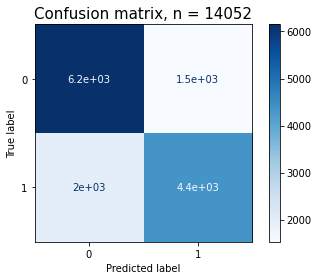

In [36]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

pcm = plot_confusion_matrix(pipe_ord, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);

plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [45]:
tp,tn,fp,fn = 4442,6165,1515,1930

precision =  tp / (tp +fp)
recall = tp / (tp+fn)

def beta(precision, recall, beta):
  return (1 + beta**.5) * (precision * recall) / ( (beta**.5)*precision + recall )

beta(precision, recall, beta=2)

0.7164398989242381

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [38]:
### 이곳에서 과제를 진행해 주세요 ### 

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


In [39]:
### 이곳에서 과제를 진행해 주세요 ###

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [40]:
### 이곳에서 과제를 진행해 주세요 ### 

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [41]:
### 이곳에서 과제를 진행해 주세요 ### 